In [1]:
from IFD_tsne import *
#from utils import load_data, MidpointNormalize, equipotential_standard_normal, plot_heatmaps
from utils import MidpointNormalize, load_data
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots import figsizes, fonts, bundles
from tueplots import cycler
from tueplots.constants import markers
from tueplots.constants.color import palettes
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif"
#})
plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
plt.rcParams.update({'figure.figsize': (2/3*5.511811263318113, 2/3*5.511811263318113)})
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])

In [2]:
def KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, _ = y2q(Y)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10)))

In [3]:
def compute_inverse_symmetric_matrix(X):
    L, lower = jax.scipy.linalg.cho_factor(X, lower=True)
    u = jax.scipy.linalg.solve_triangular(L, np.eye(np.shape(L)[0]), lower=True)
    L_t, lower = jax.scipy.linalg.cho_factor(X, lower=False)
    H_inv = jax.scipy.linalg.solve_triangular(L_t, u, lower=False)
    return H_inv

In [4]:
#X, y = make_blobs(n_samples=50, n_features=50, centers=4, random_state=0, shuffle=False, cluster_std=[0.1, 3, 3, 3])
X, y = load_data(50)
key = random.PRNGKey(41)
#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
Y_star = tsne_fwd(X, y_guess)

X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star) 

I0000 00:00:1707918247.429322       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.9248, 50 iterations in 0.2747 sec
Iteration  100, KL divergence 0.9400, 50 iterations in 0.2826 sec
Iteration  150, KL divergence 0.9895, 50 iterations in 0.2656 sec
Iteration  200, KL divergence 1.0254, 50 iterations in 0.3088 sec
Iteration  250, KL divergence 0.9030, 50 iterations in 0.2822 sec
   --> Time elapsed: 1.42 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.1778, 50 iterations in 0.2475 sec
Iteration  100, KL divergence 0.1778, 50 iterations in 0.2626 sec
Iteration  150, KL divergence 0.1778, 50 iterations in 0.2532 sec
Iteration  200, KL divergence 0.1778, 50 iterations in 0.2547 sec
Iteration 

In [5]:
dy1, H1, J1 = d_y_star_d_x_outer(KL_divergence, X, Y_star)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


In [6]:
H1_inv = np.linalg.inv(H1)

<Axes: >

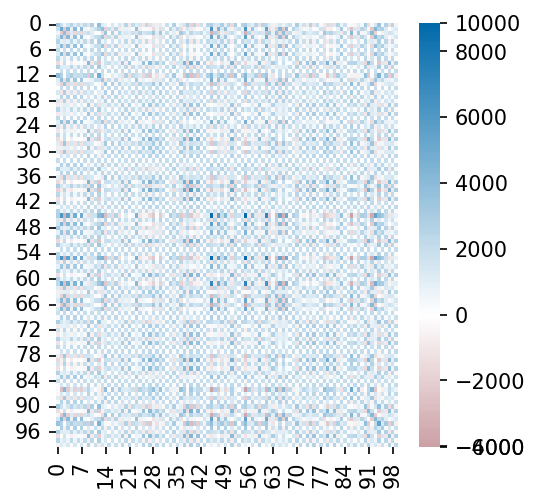

In [7]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(H1_inv, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H1_inv), vmax=np.max(H1_inv))), ax=ax1)

# Neumann Approximation

In [8]:
from Neumann import *

def get_Neumann_approximation(X_flat, X_unflattener, Y_flat, Y_unflattener, neumann_iterations=200, alpha=1):
    fun = lambda x: KL_divergence(X_flat, x, X_unflattener, Y_unflattener)
    _, f_vjp = vjp(grad(fun), Y_flat)
    v_in = np.eye(len(Y_flat))
    neumann_fun = lambda x: neumannApproximation_vis(f_vjp, x, Y_flat, neumann_iterations, alpha)
    H_inv_appr = vmap(neumann_fun)(v_in)
    return H_inv_appr

In [17]:
H_Neumann = get_Neumann_approximation(X_flat, X_unflattener, Y_flat, Y_unflattener, neumann_iterations=500, alpha=10)

Computing pairwise distances...
Starting binary search
Entered binary search function


<Axes: >

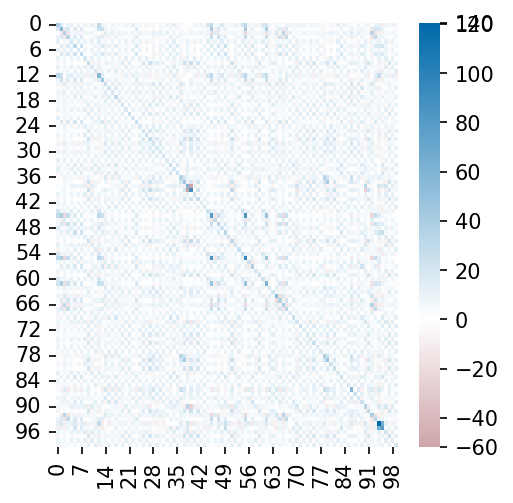

In [18]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(H_Neumann, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_Neumann), vmax=np.max(H_Neumann))), ax=ax1)

In [82]:
u, s, v = np.linalg.svd(H1)
H_low = u[:, :97] @ np.diag(s[:97]) @ v[:97, :]

# Nyström method

In [83]:
from random import sample
from sklearn.datasets import make_spd_matrix
#H1 = make_spd_matrix(100, random_state=1)
k = 80
K = sample([i for i in range(len(H1))], k)
H_K = H1[:, K]
H_KK = H_K[K, :]

In [84]:
v, w = np.linalg.eigh(H_KK)
w_sorted = np.transpose(np.transpose(w)[np.flip(np.argsort(v))])
v_sorted = np.flip(np.sort(np.abs(v)))

In [85]:
rho = 0.0001
H = 1 / rho * np.identity(len(H1))
for i in range(k):
  l = np.dot(H_K, w_sorted)[:, i]
  l_t = np.transpose(l)
  nom = np.dot(np.outer(np.dot(H, l), l_t), H)
  denom = v_sorted[i] + np.dot(np.dot(l_t, H), l)
  H = H - (nom)/(denom)


<Axes: >

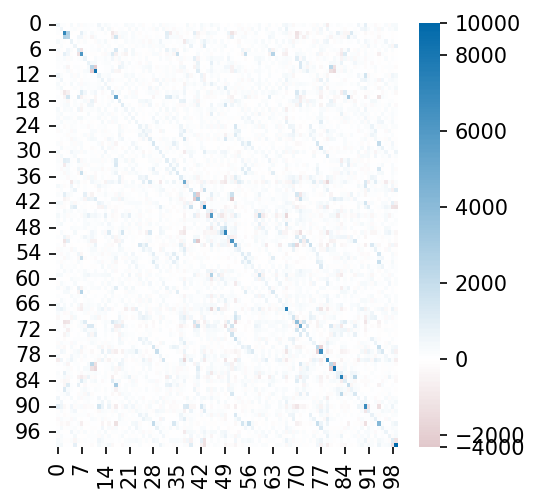

In [86]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(H, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H), vmax=np.max(H))), ax=ax1)

<Axes: >

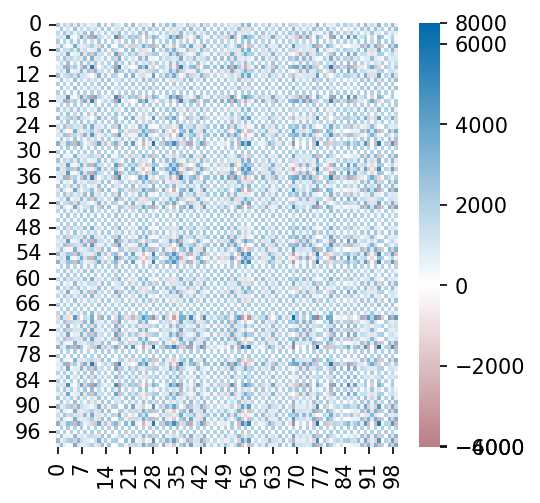

In [87]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(np.linalg.pinv(H1), cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(np.linalg.pinv(H1)), vmax=np.max(np.linalg.pinv(H1)))), ax=ax1)

In [88]:
u, s, v = np.linalg.svd(H1)
H_low = u[:, :97] @ np.diag(s[:97]) @ v[:97, :]

In [89]:
H_low

Array([[ 2.1131702e-02, -1.3304756e-03, -3.1057891e-05, ...,
         7.4535480e-04, -6.3365453e-04, -6.5862789e-04],
       [-1.3304779e-03,  2.4736907e-02,  1.7361279e-04, ...,
        -1.4719770e-03, -7.2683254e-04, -8.3971111e-04],
       [-3.1060295e-05,  1.7361790e-04,  9.2342040e-03, ...,
        -1.4057135e-05,  1.3706842e-04,  2.7044144e-04],
       ...,
       [ 7.4535457e-04, -1.4719791e-03, -1.4058455e-05, ...,
         1.3732415e-02, -1.1899728e-04, -4.7713335e-04],
       [-6.3365500e-04, -7.2683138e-04,  1.3706886e-04, ...,
        -1.1899640e-04,  7.3313420e-03,  1.3011507e-03],
       [-6.5862777e-04, -8.3970994e-04,  2.7043867e-04, ...,
        -4.7713312e-04,  1.3011526e-03,  8.6679263e-03]], dtype=float32)

In [90]:
H_g_inv = compute_inverse_symmetric_matrix(H_low + 1e-5 * np.eye(len(H_low)))

<Axes: >

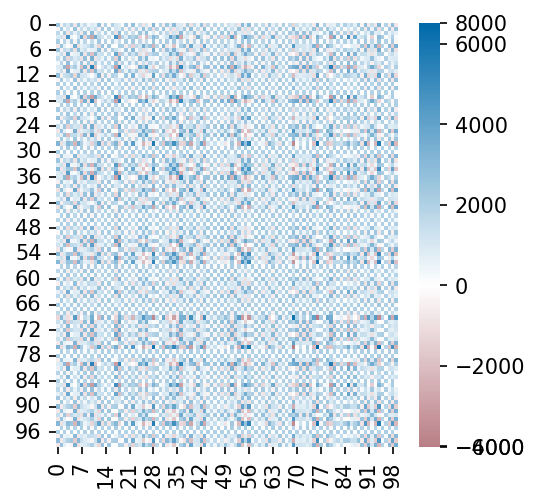

In [91]:
f, (ax1) = plt.subplots(1, 1)
sns.heatmap(H_g_inv, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_g_inv), vmax=np.max(H_g_inv))), ax=ax1)